In [1]:
# Import all necessary libraries
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Always reset the pseudo-random numbers generator to a known value so that your results are always the same.
np.random.seed(1234)

### Define a classe que implementa o gradiente descendente.

In [3]:
class MyGD:
    '''Batch gradient descent implementation.'''

    def __init__(self, alpha=0.1, maxEpochs=1, initialWeights=[]):
        '''Constructor.'''
        self.alpha = alpha
        self.maxEpochs = maxEpochs
        self.K = len(initialWeights)
        self.iteration = 0
        self.tol = 0.001
        # Create empty structures.
        self.a_hist = np.zeros((self.K, self.maxEpochs))
        self.Jgd = np.zeros(self.maxEpochs)
        # Intialize the weights.
        self.a = np.array(initialWeights).reshape(self.K, 1)

    def get_results(self):
        '''Retrieve results.'''
        return self.a, self.Jgd, self.a_hist, self.iteration

    def get_params(self):
        return {'alpha' : self.alpha, 'a' : self.a}

    def set_params(self, **params):
        self.alpha = params['alpha']
        self.a = params['a']

    def score(self, X, y_noisy):
        '''Return the mean squared error (MSE)'''
        N = len(y_noisy)
        yhat = X.dot(self.a)
        return (1.0/N)*np.sum(np.power(y_noisy - yhat, 2))

    def fit(self, X, y_noisy):
        '''Train the model with batch gradient descent.'''
        # Retrieve the number of examples.
        N = len(y_noisy)

        # Calculate the error for the initial weights.
        self.Jgd[0] = self.score(X, y_noisy)

        # Batch gradient descent loop.
        error = 1
        while(error > self.tol and self.iteration < self.maxEpochs-1):

            # Hypothesis function.
            h = X.dot(self.a)

            # Calculate gradient vector.
            gradients = -(2.0/N)*X.T.dot(y_noisy - h)

            # Weight update rule.
            self.a = self.a - self.alpha*gradients

            # Store weight variation.
            self.a_hist[:, self.iteration+1] = self.a.reshape(self.K,)

            # Calculate and store actual error.
            self.Jgd[self.iteration+1] = self.score(X, y_noisy)

            # Error difference between actual and previous iteration.
            error = np.abs(self.Jgd[self.iteration]-self.Jgd[self.iteration+1])

            # Increment iteration number.
            self.iteration += 1

### Criando o conjunto de dados.

**Função objetivo**
$$y = a_1 x_1 + a_2 x_2,$$
onde $a_1$ e $a_2$ são iguais a 1 e $x_1$ e $x_2$ são valores retirados de uma distribuição Gaussiana normal padrão.

**Função observável**
$$y_{noisy} = y + w,$$
onde $w$ é o ruído, o qual tem suas amostras retiradas de uma distribuição Gaussiana normal padrão.

In [4]:
# Number of pairs feature/label.
N = 1000

# Input values (features)
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# True model.
y = x1 + x2

# Observable function.
y_noisy = y + w

### Solução ótima com a equação normal.

**Função hipótese**
$$h(\textbf{x})=\hat{y} = \hat{a}_1 x_1 + \hat{a}_2 x_2,$$
onde $\hat{a}_1$ e $\hat{a}_2$ são aproximações dos valores originais.

In [5]:
# Closed-form solution.
X = np.c_[x1, x2]

# Normal equation.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

# Hypothesis function.
yhat = X.dot(a_opt)
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

print('--- Eq. Normal ---')
print('a1_opt', a_opt[0, 0])
print('a2_opt', a_opt[1, 0])
print('Joptimum', Joptimum)

--- Eq. Normal ---
a1_opt 1.0373518580863195
a2_opt 1.0549021717423757
Joptimum 0.9809577522249409


### Busca logaritmica do passo de aprendizagem (ajuste grosso).

In [6]:
# Gradient-descent solution.
maxEpochs = 10000

# Initial weight values.
initialWeights = [-20.0, -20.0]

# Search between 10^-4 up to 1.025.
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.025]

interations = []
scores = []
for i in range(0,len(alphas)):
    gd = MyGD(alphas[i], maxEpochs, initialWeights)
    gd.fit(X, y_noisy)
    scores.append(gd.score(X, y_noisy))
    interations.append(gd.iteration)

### Plotando os resultados.

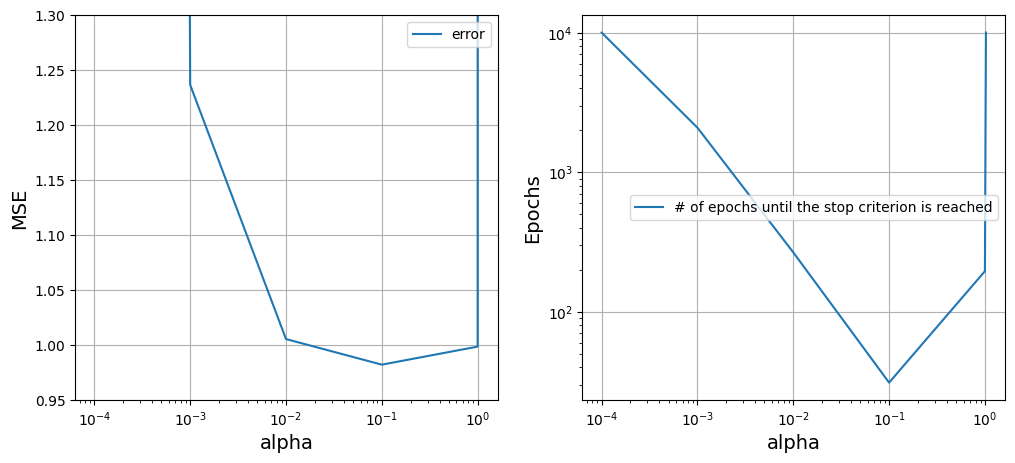

In [7]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
ax1.plot(alphas, scores, label='error')
ax1.set_xlabel('alpha', fontsize=14)
ax1.set_ylabel('MSE', fontsize=14)
ax1.legend()
ax1.set_ylim(0.95,1.3)
ax1.set_xscale('log')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(alphas, interations, label='# of epochs until the stop criterion is reached')
ax2.set_xlabel('alpha', fontsize=14)
ax2.set_ylabel('Epochs', fontsize=14)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend()
ax2.grid()

#plt.savefig("grid_search1.png", dpi=600)
plt.show()

#### Observações

+ Passos pequenos fazem com que o algoritmo leve mais tempo para convergir, podendo fazer com que o algoritmo pare longe do ponto de mínimo.

+ Passo ideal: menor erro possível e convergência rápida.

+ Após o passo ideal, conforme o passo aumenta, o valor fica grande o suficiente para fazer com que o algoritmo pule de um lado para o outro do ponto de mínimo, mas por sorte, ele converge.

+ Passos muito grandes fazem com que o algoritmo pule de um lado para o outro do ponto de mínimo, sempre se distanciando dele, fazendo com que o algoritmo divirja.

### Ajuste fino em torno do melhor valor do passo de aprendizagem encontrado na etapa anterior.

In [8]:
# Gradient-descent solution.
maxEpochs = 10000

initialWeights = [-20.0, -20.0]

alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

interations = []
scores = []
for i in range(0,len(alphas)):
    gd = MyGD(alphas[i], maxEpochs, initialWeights)
    gd.fit(X, y_noisy)
    scores.append(gd.score(X, y_noisy))
    interations.append(gd.iteration)

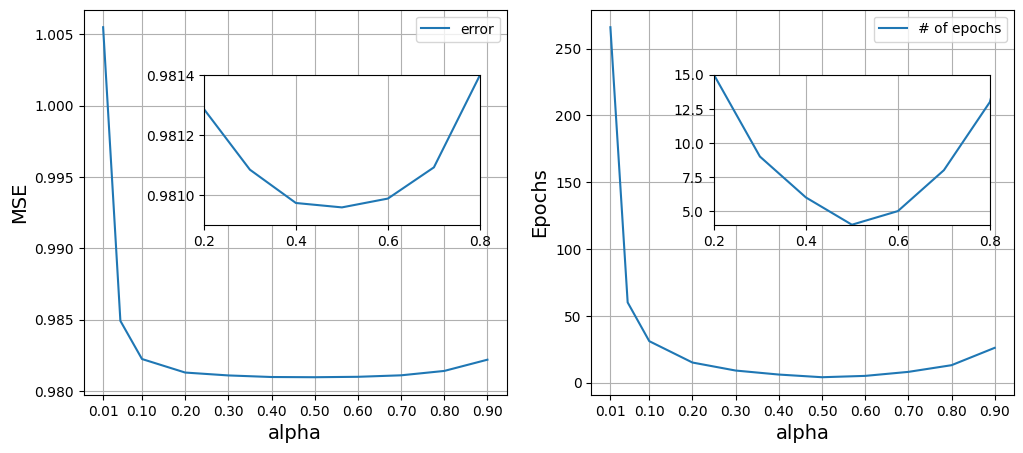

In [9]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
ax1.plot(alphas, scores, label='error')
ax1.set_xlabel('alpha', fontsize=14)
ax1.set_ylabel('MSE', fontsize=14)
ax1.set_xticks([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(alphas, interations, label='# of epochs')
ax2.set_xlabel('alpha', fontsize=14)
ax2.set_ylabel('Epochs', fontsize=14)
ax2.set_xticks([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
ax2.legend()
ax2.grid()

left, bottom, width, height = [0.225, 0.45, 0.23, 0.3]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot(alphas, scores)
ax3.set_xlim(0.2, 0.8)
ax3.set_ylim(0.9809, 0.9814)
ax3.grid()

left, bottom, width, height = [0.65, 0.45, 0.23, 0.3]
ax4 = fig.add_axes([left, bottom, width, height])
ax4.plot(alphas, interations)
ax4.set_xlim(0.2, 0.8)
ax4.set_ylim(4, 15)
ax4.grid()

#plt.savefig("grid_search2.png", dpi=600)
plt.show()

### Conclusão

+ Melhor valor para o passo de aprendizagem é 0.5.

### Observação

+ Existem ferramentas (i.e., bibliotecas) muito melhores (i.e., especializadas) para se fazer o ajuste do passo de aprendizagem (e qualquer outro hiperparâmetro), como por exemplo, o optuna (https://optuna.org/) e o próprio Scikit-learn, que possui algumas classes para otimização hiperparamétrica: GridSearchCV e RandomizedSearchCV.
